In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/MyDrive/DL/

Mounted at /content/drive/
/content/drive/MyDrive/DL


## Part 1
#### To-do
* Note that `predict` method should take as input a tensor with values in 0-255 and should output a tensor with values in 0-255
* Test with RED30 model

In [ ]:
import torch.nn as nn

## PART 2 : Test the requested netwok using PyTorch to be able to compare with our implementation
class SimpleNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SimpleNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, 64, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 2, stride=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, out_ch, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)

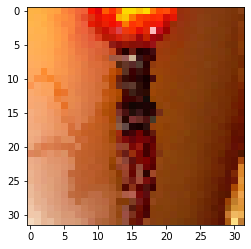

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.set_grad_enabled(True)

train_dir = "train_data.pkl"
val_dir = "val_data.pkl"
noisy_imgs_1 , noisy_imgs_2 = torch.load("train_data.pkl")
noisy_imgs , clean_imgs = torch.load("val_data.pkl")

plt.imshow((noisy_imgs_1[1].float()/255.0).permute(1, 2, 0))

In [ ]:
from train import *
from unet import *
import torch.nn as nn
import torch.optim as optim

model = SimpleNet(3, 3)
optim = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

model_outputs = train_model(load_model=False, save_model=False, 
                            model=model, optimizer=optim, loss_fn=loss_fn, 
                            batch_size=100, num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[PSNR : 12.35 dB], PSNR before training = 20.72 dB


In [ ]:
from utils import *

i = 10
plot_prediction_clean(noisy_imgs[i].float()/255.0, clean_imgs[i].float()/255.0, model_outputs[i])

## Part 2
* Implementation of Conv2d : https://coolgpu.github.io/coolgpu_blog/github/pages/2020/10/04/convolution.html and https://github.com/coolgpu/Demo_Conv2d_forward_and_backward/blob/master/my_conv2d_v1.py
* Implementation of transposed convolution (if needed) : https://coolgpu.github.io/coolgpu_blog/github/pages/2021/02/18/transposed_convolution.html
* Chain rule gradients and stuff : https://coolgpu.github.io/coolgpu_blog/github/pages/2020/09/14/backpropagation.html#_Derivation_of_the_gradients
#### To-do
* Weight initialization function (for example xavier init) ? see https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
* Refine modules so that their arguments match exactly their pytorch counterparts
* put everything on torch.to(DEVICE)

In [ ]:
import torch
torch.set_grad_enabled(False)

In [ ]:
from torch import empty, cat, arange
from torch.nn.functional import fold, unfold
import math

class Conv2d(object):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, device=None):
        self.id = 'Conv2d'
        self.device = device
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        mean = 0
        std = math.sqrt(2.0 / (kernel_size*kernel_size*out_channels))
        self.weights = torch.empty((out_channels, in_channels, kernel_size, kernel_size), dtype=torch.float).normal_(mean=mean, std=std)
        self.grad_weights = torch.empty((out_channels, in_channels, kernel_size, kernel_size), dtype=torch.float).zero_()    
        self.bias = None
        self.grad_bias = None
        if bias:
            self.bias = torch.empty((out_channels), dtype=torch.float).normal_(mean=mean, std=std)#.fill_(1e-3)
            self.grad_bias = torch.empty((out_channels), dtype=torch.float).zero_()
        if device is not None:
          self.weights = self.weights.to(device)
          self.grad_weights = self.grad_weights.to(device)
          self.bias = self.bias.to(device)
          self.grad_bias = self.grad_bias.to(device)

    
    def forward(self, input_t):
        assert input_t.ndim == 4 and input_t.shape[1] == self.in_channels, f"input tensor should be of shape (nImages, {self.in_channels}, Y, X)"

        self.in_size_y = input_t.shape[2]
        self.in_size_x = input_t.shape[3]
        
        #General formula for computing the output sizes of images depending on the input size, the kernel size, the padding and the stride.
        self.out_size_y = ((self.in_size_y + 2*self.padding - self.kernel_size) // self.stride) + 1
        self.out_size_x = ((self.in_size_x + 2*self.padding - self.kernel_size) // self.stride) + 1
        
        #Here we use unfold to facilitate the sliding window operations of our convolution
        # unfold takes an input a tensor of shape (N, C, Y, X) where N is the number of 2D images, C is the number of channels per image, 
        # Y, X is the dimension of each 2D image. Unfold also takes as input the kernel size K (in our convolution we assume the kernel to always be a square, thus number of elements in kernel is K*K).
        # For each image, unfold extracts patches of same size as the kernel size, for each channel.
        # Each patch can be seen a 1D vertical vector (instead of a 2D matrix), and patches of the same channel are concatenated so as to obtain, for one channel, a 2D matrix of shape (K*K, out_size_y*out_size_x). Patches are concatenated in order from left to right and from top to bottom.
        # Then matrices of each channel are concatenated vertically so as to obtain a 2D matrix of shape (C*K*K, out_size_y*out_size_x). Matrices are concatenated in order of channels.
        # out_size_y represents the Y axis of output image, out_size_x represents the X axis of output image.
        # Since this procedure is done for each image, the resulting tensor of unfold is of shape (N, C*K*K, out_size_y*out_size_x).
        patch_tensor = torch.nn.functional.unfold(input_t, (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        
        #Useful for backward pass
        self.input_unfolded = patch_tensor
        
        # Transpose the patches tensor so as to obtain, for each image, the C patches of same location in a row instead of in a column.
        patch_tensor = patch_tensor.transpose(1, 2)
        
        #Reshape the kernel so as to match the shape of patches in patches tensor. Note that each row in the patches tensor is of size C*K*K,
        # and each row in the reshaped kernel is also of size (C*K*K).
        kernel_w = self.weights.view(self.out_channels, -1)
        
        #For matrix multiplication (apply the kernel on the patches) of the patches tensor with the reshaped kernel, we transpose the reshaped kernel so as to have C*K*K rows.
        kernel_w = kernel_w.t()
        
        #Matrix multiplication, i.e. apply kernel on patches
        #Resulting conv has shape (N, out_size_y*out_size_x, out_channels)
        conv = patch_tensor @ kernel_w
        
        #Transpose and reshape to match the input tensor shape (batch of images), get shape (N, out_channels, out_size_y, out_size_x)
        output_t = conv.transpose(1, 2).reshape(input_t.shape[0], self.out_channels, self.out_size_y, self.out_size_x)
        
        #Add bias if needed
        if self.bias is not None:
            output_t += self.bias.view(1, self.out_channels, 1, 1)
        
        return output_t
        
    def backward(self, grad_output):
        assert grad_output.ndim == 4 and grad_output.shape[1] == self.out_channels and grad_output.shape[2] == self.out_size_y and grad_output.shape[3] == self.out_size_x, f"input tensor should be of shape (nImages, {self.out_channels}, {self.out_size_y}, {self.out_size_x})"
        
        #Reshape into (N, out_channels, out_size_y*out_size_x)
        grad_out_reshaped = grad_output.reshape(grad_output.shape[0], self.out_channels, -1)
        
        #Transpose to pass channels in last dimension to get (N, out_size_y*out_size_x, out_channels)
        grad_out_reshaped = grad_out_reshaped.transpose(1, 2)
        
        #Compute gradient of loss wrt input using the kernel weights. Resulting shape (N, out_size_y*out_size_x, C*K*K).
        #C = A@B => d_l/d_A = d_l/d_C @ B.t, out = in@weights => d_l/d_in = d_l/d_out @ weights
        grad_input_unfolded = grad_out_reshaped @ self.weights.view(self.out_channels, -1)
        
        #Reshape gradient of loss wrt input by "unpatching" the images to obtain a (N, C, in_size_y, in_size_x) tensor
        grad_input = torch.nn.functional.fold(grad_input_unfolded.transpose(1, 2), (self.in_size_y, self.in_size_x), (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        assert grad_input.shape == (grad_output.shape[0], self.in_channels, self.in_size_y, self.in_size_x)
        
        #Compute gradient of loss wrt weight kernel. Resulting shape (N, C*K*K, out_channels)
        #C = A@B => d_l/d_B = A.t @ d_l/d_C, since out=in@w (unfolded), d_l/d_w = in.t @ d_l/d_out
        grad_weights = self.input_unfolded @ grad_out_reshaped
        
        #Sum over the batch of N images (sum over the gradients of images). Resulting shape (C*K*K, out_channels)
        grad_weights = grad_weights.sum(dim=0)
        
        #Reshape to obtain original weights shape (out_channels, in_channels (C), K, K)
        self.grad_weights.add_(grad_weights.t().view(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        
        if self.bias is not None:
            #For each image, sum over full image to obtain 1 bias value for each "out_channel" channel.
            #Sum over the batch of N images (sum over the gradients of images). Resulting shape (out_channels).
            self.grad_bias.add_(grad_output.sum(dim=[0, 2, 3]))
        return grad_input
        
    def parameters(self):
        return [(self.weights, self.grad_weights), (self.bias, self.grad_bias)]

In [ ]:
class Upsample(object):
    
    def __init__(self, scale_factor=1, device=None):
        assert isinstance(scale_factor, int) and scale_factor > 0, "scale factor should be a positive integer"
        self.id = 'Upsample'
        self.device = device
        self.scale_factor = scale_factor
    
    def forward(self, input_t):
        #self.input_t = input_t # to get shape later on
        first_upsample = input_t.repeat_interleave(self.scale_factor, dim=2)
        second_upsample = first_upsample.repeat_interleave(self.scale_factor, dim=3)
        return second_upsample
        
    def backward(self, grad_output): # basically 'num_channels' convolutions
        in_size_y = grad_output.shape[2]
        in_size_x = grad_output.shape[3]
        
        out_size_y = ((in_size_y - self.scale_factor) // self.scale_factor) + 1
        out_size_x = ((in_size_x - self.scale_factor) // self.scale_factor) + 1
        
        patch_tensor = torch.nn.functional.unfold(grad_output, (self.scale_factor, self.scale_factor), padding=0, stride=self.scale_factor)
        patch_tensor = patch_tensor.reshape((grad_output.shape[0], grad_output.shape[1], self.scale_factor*self.scale_factor, -1))
        output_t = patch_tensor.sum(2).reshape((grad_output.shape[0], grad_output.shape[1], out_size_y, out_size_x))
        
        return output_t
        
    def parameters(self): #no params on upsampling layers
        return []

In [ ]:
class Sigmoid(object):
    
    def __init__(self, device=None):
        self.id = 'Sigmoid'
        self.device = device
        
    def forward(self, input_t):
        self.sig = input_t.sigmoid()
        return self.sig
        
    #grad_output is d_l/d_x and we want to compute d_l/d_s
    def backward(self, grad_output):
        #sig*(1-sig)
        grad_sig = self.sig.mul(1-self.sig)
        grad_sig = grad_output.mul(grad_sig)
        return grad_sig
        
    def parameters(self):
        return []

In [ ]:
class ReLU(object):
    
    def __init__(self, device=None):
        self.id = 'ReLU'
        self.device = device

    def forward(self, input_t):
        #max(0, x)
        torch_zeros = torch.empty(input_t.shape).fill_(0)
        if device is not None:
            torch_zeros = torch_zeros.to(device)
        self.relu = input_t.maximum(torch_zeros)
        return self.relu
        
        
    def backward(self, grad_output):
        #sign(max(0, x))
        grad_relu = self.relu.gt(0).int().float()
        return grad_output.mul(grad_relu)
        
    def parameters(self):
        return []

In [ ]:
class Sequential(object):
    def __init__(self, *modules):
        self.id = 'Sequential'
        self.modules = [m for m in modules]

    def modules():
        return self.modules
    
    def forward(self, input_t):
        x = input_t.clone()
        #print(f"forward 1st:{x.shape}")
        for i in range(len(self.modules)):
            #if i==0:
              #y = nn.Conv2d(3, 64, 3, stride=2, padding=1)
              #z = y(x)
              #print(z)
            x = self.modules[i].forward(x)
            #if i == 0:
              #print("====================================")
              #print(x)
              #print(x.equal(z))

            #print(f"forward:{x.shape}")
        return x
        
    def backward(self, grad_output):
        x = grad_output.clone()
        #print(f"backward 1st:{x.shape}")
        #j=0
        for i in reversed(range(len(self.modules))):
            x = self.modules[i].backward(x)
            #if j==0:
              #print(x)
            #j = j+1
            #print(f"backward:{x.shape}")
        #print(x)
        return x
        
    def parameters(self):
        params = []
        for module in self.modules:
            if module.id == 'Sequential':
                for seq_module in module.parameters():
                    params = params + seq_module.parameters()
            elif module.parameters():
                params = params + module.parameters()
        return params

In [ ]:
class MSELoss(object):
    
    def __init__(self):
        pass
    
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target).square().mean()
        
    def backward(self):
        return 2 * (self.pred - self.target) / self.pred.numel()
        
    def parameters(self):
        return []

In [ ]:
class CustomNN(object):
    def __init__(self, in_ch, out_ch, device=None):
        self.seq = Sequential(
            Conv2d(in_ch, 64, 2, stride=2, device=device),
            ReLU(device=device),
            Conv2d(64, 128, 2, stride=2, device=device),
            ReLU(device=device),
            Upsample(scale_factor=2, device=device),
            Conv2d(128, 64, 3, padding=1, device=device),
            ReLU(device=device),
            Upsample(scale_factor=2, device=device),
            Conv2d(64, out_ch, 3, padding=1, device=device),
            Sigmoid(device=device)
        )
        self.params = self.seq.parameters()
        
    def forward(self, x):
        return self.seq.forward(x)
    
    def backward(self, grad_loss):
        return self.seq.backward(grad_loss)
    
    def parameters(self):
        return self.params

In [ ]:
class SGD(object):
    def __init__(self, model_params, lr=0.001, device=None):
        self.model_params = model_params
        self.lr = lr
        
    def step(self):
        for w, grad_w in self.model_params:
            if w is not None and grad_w is not None:
                w.sub_(self.lr*grad_w)

    def zero_grad(self):
        for w, grad_w in self.model_params:
            if w is not None and grad_w is not None:
                grad_w.zero_()

In [ ]:
class Adam(object):
    def __init__(self, model_params, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, device=None):
        self.m_dw = {}
        self.v_dw = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
        self.model_params = model_params
        self.t = 1
        for i in range(len(self.model_params)):
            self.m_dw[i] = torch.empty(self.model_params[i][1].shape).zero_()
            self.v_dw[i] = torch.empty(self.model_params[i][1].shape).zero_()
            if device is not None:
                self.m_dw[i] = self.m_dw[i].to(device)
                self.v_dw[i] = self.v_dw[i].to(device)
        

    def step(self):
        for i in range(len(self.model_params)):
            if self.model_params[i][0] is not None and self.model_params[i][1] is not None:
                curr_mean = self.m_dw[i]
                curr_speed = self.v_dw[i]
                
                self.m_dw[i] = self.beta1*curr_mean + (1-self.beta1)*self.model_params[i][1]

                self.v_dw[i] = self.beta2*curr_speed + (1-self.beta2)*(self.model_params[i][1].square())

                m_estimate = self.m_dw[i]/(1-(self.beta1**self.t))
                v_estimate = self.v_dw[i]/(1-(self.beta2**self.t))

                self.model_params[i][0].sub_(self.eta*(m_estimate/(v_estimate.sqrt()+self.epsilon)))

        self.t = self.t + 1

    def zero_grad(self):
        for i in range(len(self.model_params)):
            if self.model_params[i][0] is not None and self.model_params[i][1] is not None:
                self.model_params[i][1].zero_()

In [ ]:
from torch.utils.data import Dataset

class NoisyDataset(Dataset):
    def __init__(self, X, Y):
        assert X.shape == Y.shape and X.ndim == 4
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from train import compute_psnr
import matplotlib.pyplot as plt

batch_size = 10
lr = 1e-3
eta = 1e-3
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomNN(3, 3, device=device)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), eta=eta, device=device)
#optimizer = SGD(model.parameters(), lr=lr, device=device)

train_input0, train_input1 = torch.load("train_data.pkl")
train_input0 = train_input0.float() / 255.0
train_input1 = train_input1.float() / 255.0
val_input, val_target = torch.load("val_data.pkl")
val_input = val_input.float() / 255.0
val_target = val_target.float() / 255.0

output_psnr_before = compute_psnr(val_input, val_target)

for i in range(num_epochs):
  dataset = NoisyDataset(train_input0, train_input1)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  loop = tqdm(dataloader)

  for data, targets in loop:
      data = data.to(device)
      targets = targets.to(device)

      # forward
      predictions = model.forward(data)
      loss = loss_fn.forward(predictions, targets)

      # backward
      optimizer.zero_grad()
      model.backward(loss_fn.backward())
      optimizer.step()

      lr = lr

      loop.set_postfix(loss=loss.item())

mini_batch_size = 100
model_outputs = []
for b in tqdm(range(0, val_input.size(0), mini_batch_size)):
    output = model.forward(val_input.narrow(0, b, mini_batch_size).to(device))
    model_outputs.append(output)
model_outputs = torch.cat(model_outputs, dim=0).cpu()

output_psnr_after = compute_psnr(model_outputs, val_target)
print(f"[PSNR : {output_psnr_after:.2f} dB], PSNR before training = {output_psnr_before:.2f} dB")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[PSNR : 23.17 dB], PSNR before training = 20.72 dB


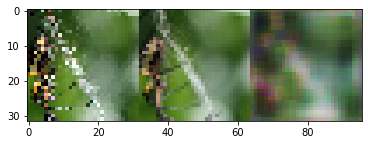

In [ ]:
from utils import *

i = 10
plot_prediction_clean(val_input[i], val_target[i], model_outputs[i])

In [ ]:
import torch
import torch.nn as nn

up = Upsample(scale_factor=2)

ones = torch.rand((2, 2, 4, 4))
target = torch.ones((2, 2, 2, 2))
for i in range(target.shape[0]):
    for j in range(target.shape[1]):
        for k in range(target.shape[2]):
            for l in range(target.shape[3]):
                target[i, j, k, l] = ones[i, j, 2*k, 2*l] + ones[i, j, 2*k+1, 2*l] + ones[i, j, 2*k, 2*l+1] + ones[i, j, 2*k+1, 2*l+1]

out = up.backward(ones)

print(out)
print(target)

tensor([[[[2.3191, 1.8522],
          [2.4779, 2.4621]],

         [[1.1714, 2.0257],
          [1.3062, 1.6910]]],


        [[[1.7460, 1.5137],
          [1.9270, 1.7127]],

         [[1.8542, 2.0028],
          [2.7243, 2.0806]]]])
tensor([[[[2.3191, 1.8522],
          [2.4779, 2.4621]],

         [[1.1714, 2.0257],
          [1.3062, 1.6910]]],


        [[[1.7460, 1.5137],
          [1.9270, 1.7127]],

         [[1.8542, 2.0028],
          [2.7243, 2.0806]]]])
